# Installing Segment Anything and other requirements

## Links:


1. GitHub: https://github.com/facebookresearch/segment-anything?fbclid=IwAR0Y2u97N1GZXS9FZL4pJRkNsrRrgvg8D9igcKqyuMhA0SftslAzw92WE-g
2. Meta AI: https://ai.facebook.com/blog/segment-anything-foundation-model-image-segmentation/?utm_source=linkedin&utm_medium=organic_social&utm_campaign=segmentanything&utm_content=gif
3. Segment Anything Paper: https://ai.facebook.com/research/publications/segment-anything/



### Segment Anything:

# SAM Segmentation after YOLO Detection

### ----------------------- Main Code --------------------

##### *** The final centroid should be x1 + x and y1 + y (Need to test)

### *** Run this if running on Google colab ***

In [1]:
import torch
import warnings
import sys
import torch
import torchvision
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
import time
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import os
import warnings

In [2]:
if 'google.colab' in str(get_ipython()):  # Checking if running on google colab
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib --quiet
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git' --quiet
    
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

    from google.colab import drive
    drive.mount('/content/drive')

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Preparing metadata (setup.py) ... done
--2023-05-26 17:08:50--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.165.83.44, 18.165.83.79, 18.165.83.35, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.165.83.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   202MB/s    in 11s     

2023-05-26 17:09:00 (231 MB/s) - ‘sam_vit_h_4b8939.pth.1’ saved [2564550879/2564550879]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Installing and Instantiating SAM:

In [3]:
!pip install git+https://github.com/facebookresearch/segment-anything.git --quiet
!pip install opencv-python pycocotools matplotlib onnxruntime onnx --quiet

  Preparing metadata (setup.py) ... done


In [4]:
sam_checkpoint = "sam_vit_h_4b8939.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
  print('CUDA is found! Executing on %s.......'%torch.cuda.get_device_name(0))
else:
  warnings.warn('CUDA not found! Execution may be slow......')

model_type = "default"

CUDA is found! Executing on Tesla T4.......


In [5]:
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

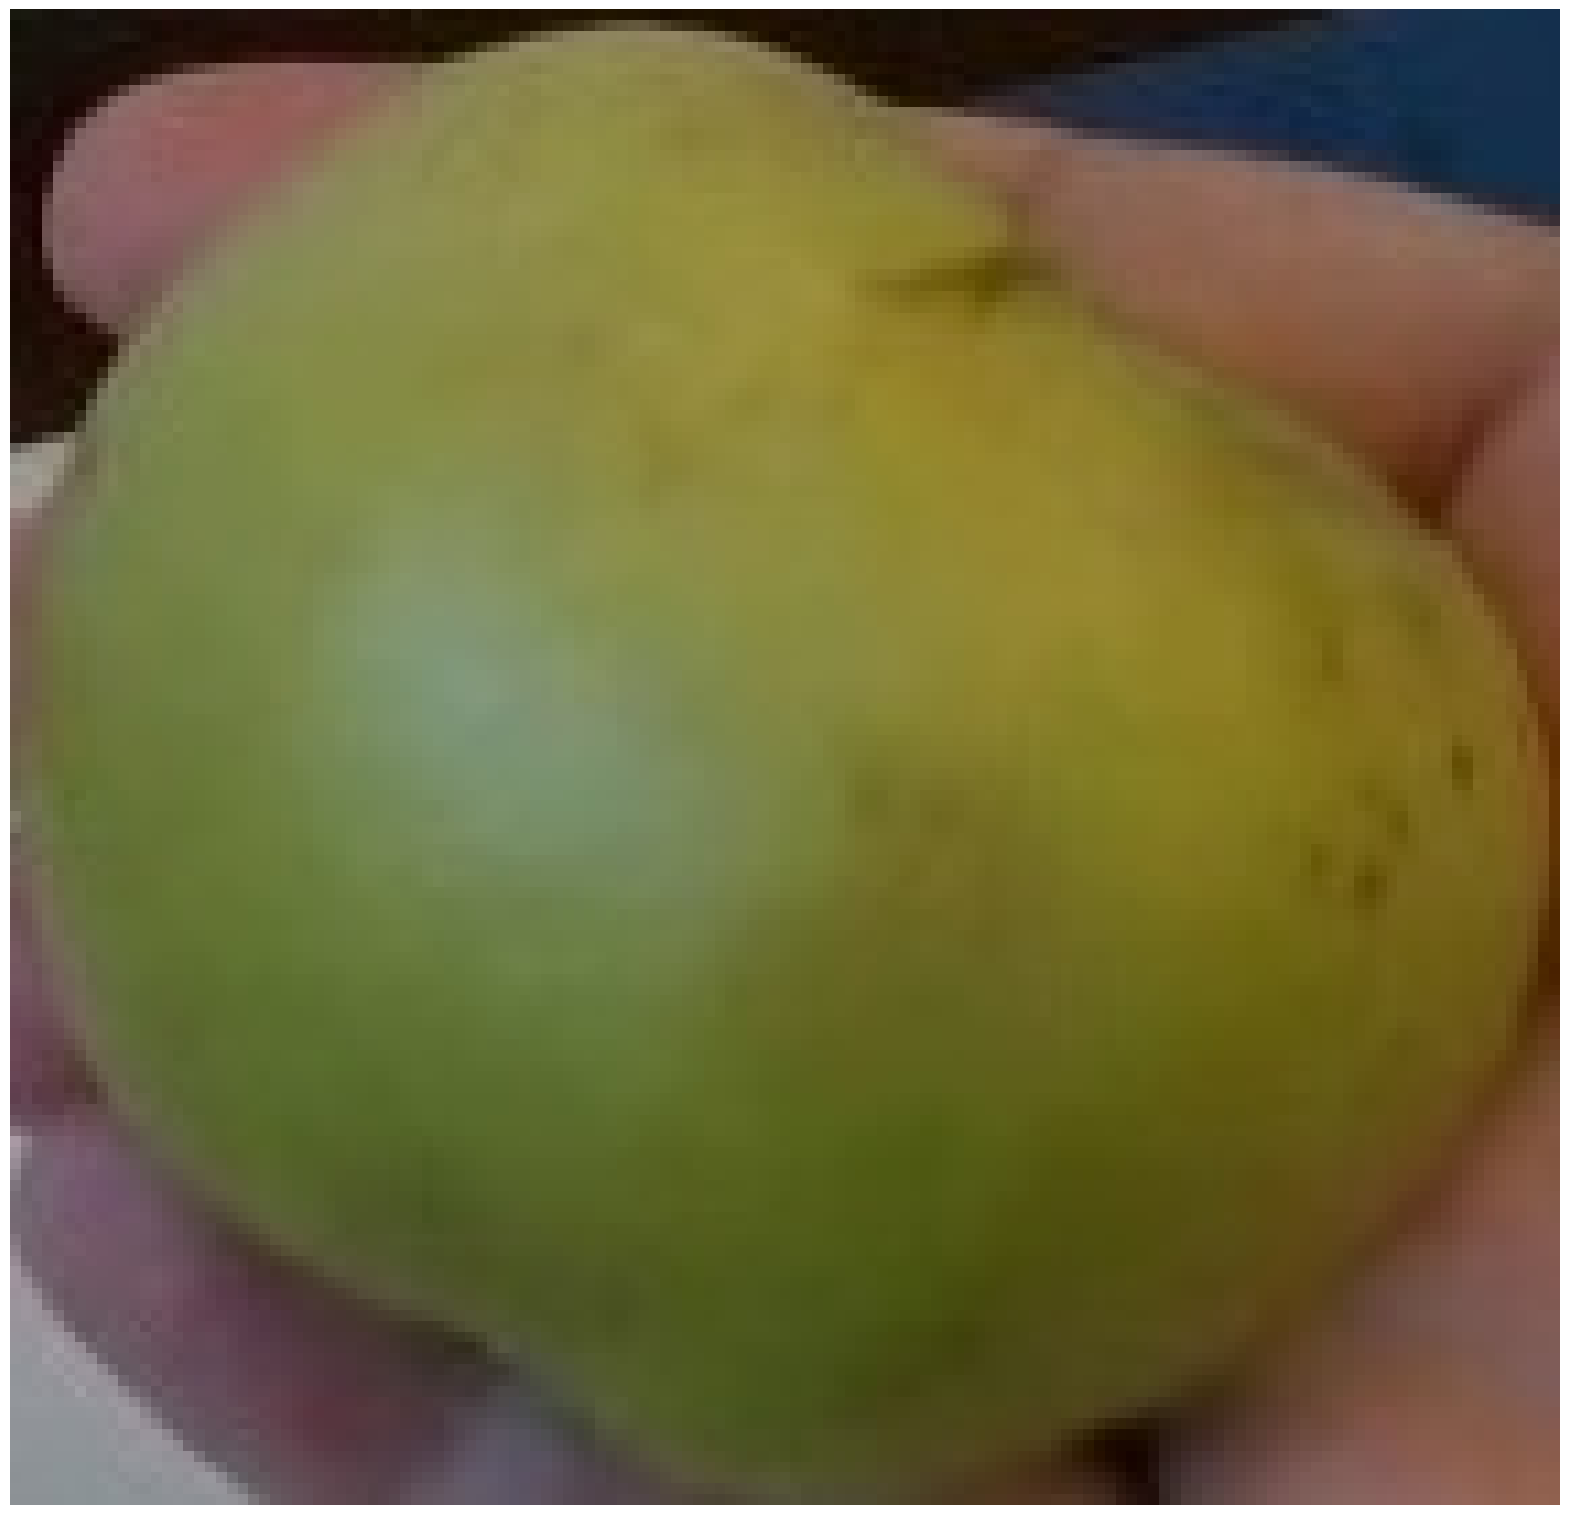

In [6]:
# cropped_apple = cv2.imread('/content/drive/MyDrive/Fluid Segmentation Drive/crop_104.jpg')
cropped_apple = cv2.imread('/content/drive/MyDrive/Fluid Semantic Drive/META [Segment Anything]/Dataset/crop_104.jpg')
cropped_apple = cv2.cvtColor(cropped_apple, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,20))
plt.imshow(cropped_apple)
plt.axis('off')
plt.show()

-- Given an image like above:
> Generate segmentation mask for the image.
> ---> Sort the masks based on their sizes
> ---> Get the point-of-interest (POI) mask (the mask with maximum area)
> ---> Display the mask (optional for final)
> ---> Get the centroid of POI mask, return the centroid
> ---> Convert the centroid to accomodate the entire scene (whole image) 

** The images sent to SAM are cropped images. The centroid returned is in the form of cropped_image reference. Convert this to enitre frame centroid by adding x1 and y1 values (Need to test it).

---> x1 + centroid x; y1 + centroid y


## TODO: (Later)

- Import SAM model (maybe integrate it with another function)

In [7]:
# Calculates the centroid of the object
def get_centroid(mask_segmentation):
  binary_mask = mask_segmentation.astype(np.uint8)

  y, x = np.indices(binary_mask.shape)
  centroid_x = int(np.sum(x * binary_mask) / np.sum(binary_mask))
  centroid_y = int(np.sum(y * binary_mask) / np.sum(binary_mask))

  return centroid_x, centroid_y

In [8]:
def disp_mask_and_centroid(image, anns, random_color=False, disp_centroid=True):
    # num_masks = 
    if len(anns) == 0:
        return
  
     # Sort masks based on 'area' in descending order
    sorted_masks = sorted(anns, key=lambda x: x['area'], reverse=True)
    
    # Select point-of-interest mask
    poi_mask = sorted_masks[0]['segmentation']

    #Compute the centroid of the mask
    cent_x, cent_y = get_centroid(poi_mask)

    # Create an empty mask of zeros with the same shape as image
    mask_overlay = np.zeros(image.shape, dtype=np.uint8)
      
    # Convert the mask to uint8
    poi_mask = (poi_mask * 255).astype(np.uint8)

    # Find contours from the binary mask
    contours, _ = cv2.findContours(poi_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Fill the poi_mask area with a specified color
    color = (255, 165, 0) if not random_color else tuple(np.random.randint(0, 255, 3).tolist())  # orange or random color
    cv2.drawContours(mask_overlay, contours, -1, color, thickness=cv2.FILLED)

    # Bitwise operation to put mask on top of image
    img = cv2.bitwise_and(image, mask_overlay)

    # If you want to show centroid, draw a small circle
    if disp_centroid:
        cv2.circle(img, (cent_x, cent_y), 5, (0, 255, 255), -1)  # Red color for centroid

        # Specify the font
        font = cv2.FONT_HERSHEY_SIMPLEX

        # Specify the color
        color = (255, 0, 0)  # Red color

        # Specify the size
        size, thickness = 0.75, 2

        coordinates_text = f"({cent_x}, {cent_y})"
        cv2.putText(img, coordinates_text, (cent_x - 50, cent_y - 10), font, size, color, thickness)


    img_ = cv2.bitwise_not(img)

    # Create a mask where white (255) pixels in the overlay image are black (0) 
    mask = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(mask, 254, 255, cv2.THRESH_BINARY_INV)

    # Split the mask into 3 channels
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    # Create a masked foreground and background
    foreground = cv2.bitwise_and(img_, mask)
    background = cv2.bitwise_and(image, cv2.bitwise_not(mask))

    # Combine the foreground and the background
    output_img = cv2.add(foreground, background)


    return cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB), cent_x, cent_y

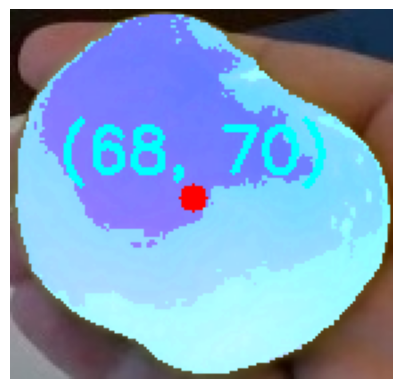

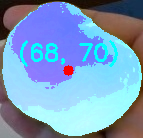

In [9]:
cropped_apple_mask = mask_generator.generate(cropped_apple)
final_img, centroid_x, centroid_y = disp_mask_and_centroid(cropped_apple, cropped_apple_mask)

plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_RGB2BGR))  # OpenCV uses BGR color order, so it needs to be converted to RGB for correct display
plt.axis('off')
plt.show()
#%%%%#
cv2_imshow(final_img)

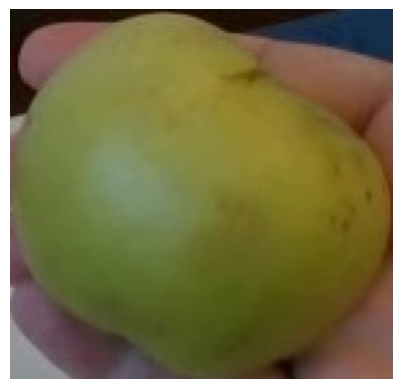

In [10]:
plt.imshow(cropped_apple)  # OpenCV uses BGR color order, so it needs to be converted to RGB for correct display
plt.axis('off')
plt.show()

In [11]:
print(cropped_apple_mask[0])

{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 13541, 'bbox': [2, 2, 139, 133], 'predicted_iou': 1.0161386728286743, 'point_coords': [[118.421875, 109.96875]], 'stability_score': 0.9735171794891357, 'crop_box': [0, 0, 143, 138]}


## Combining SAM and YOLO:


### Links:
1. Yolo_v8 Detect: https://docs.ultralytics.com/tasks/detect/
2. Yolo_v8 Colab: https://colab.research.google.com/github/ultralytics/ultralytics/blob/main/examples/tutorial.ipynb#scrollTo=yq26lwpYK1lq


### Download and instantiate YOLO:


#### ------------- Testing with YOLO v8 -------------

In [12]:
!pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.109 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.2/166.8 GB disk)


In [13]:
from ultralytics import YOLO
model_path = '/content/drive/MyDrive/Fluid Segmentation Drive/yolov8n.pt'
YOLO = YOLO(model_path)  # load a pretrained YOLOv8n detection model


#### ------------------------------------------------

In [14]:
# !pip install torch torchvision opencv-python
# !pip install yolov5
# !wget https://github.com/ultralytics/yolov5/releases/download/v5.0/yolov5s.pt

In [15]:
# # Load the YOLOv5 model
# YOLO = torch.hub.load('ultralytics/yolov5', 'yolov5s')

### Process the video:

In [20]:
def YOLO_SAM_Centroid(frame, model, poi='', yolo_centroid=True, sam_centroid=False, return_frame=True, 
                      display_mask=False, yolo_all=False):

    if yolo_all or poi=='': # Work here: Assume yolo_centroid +
          all_obj_img, x1, y1, x2, y2 = detect_objects(frame, model, detect_all=yolo_all)
          warnings.warn("Warning! No point-of-interest object mentioned in 'poi' field. Returning bounding boxes of all items.")
    
    og_img = frame.copy()
    start_time_yolo = time.time()
    # Perform object detection on the current frame
    cropped_img, x1, y1, x2, y2 = detect_objects(frame, model, poi)
    end_time_yolo = time.time()

    if x1 == 0:
      frame = cropped_img
      if return_frame:
          return frame, 0, 0
      else:
          return 0, 0

    else:
      if yolo_centroid: # Approximate and display the centroid using yolo bounding box
          # frame = cropped_img
          # Specify the color
          color = (0, 255, 0)  # Green color -> BGR

          # Specify the thickness
          thickness = 2

          # Specify the length of the lines of the cross
          line_length = 5  

          # Approximate the centroid using yolo bounding box
          yolo_centX = (x2 + x1)//2
          yolo_centY = (y2 + y1)//2

          # print("YOLO Approximation centroid: x={}, y={}\n".format(yolo_centX, yolo_centY))
          # Draw the first line of the cross (from top-left to bottom-right)
          cv2.line(frame, (yolo_centX - line_length, yolo_centY - line_length), 
                          (yolo_centX + line_length, yolo_centY + line_length), color, thickness)

          # Draw the second line of the cross (from top-right to bottom-left)
          cv2.line(frame, (yolo_centX + line_length, yolo_centY - line_length), 
                          (yolo_centX - line_length, yolo_centY + line_length), color, thickness)

          # Specify the font
          font = cv2.FONT_HERSHEY_SIMPLEX

          # Specify the size
          size, thickness = 0.75, 2

          coordinates_text = f"({yolo_centX}, {yolo_centY})"
          cv2.putText(frame, coordinates_text, (yolo_centX - 50, yolo_centY - 50), font, size, color, thickness)

          centroid_x, centroid_y = yolo_centX, yolo_centY

      elif sam_centroid:
          start_time_sam = time.time()
          cropped_mask = model.generate(cropped_img)
          end_time_sam = time.time()
          print("Time elapsed SAM: {}s".format(np.abs(end_time_sam - start_time_sam)))

          cropped_mask_img, centroid_x, centroid_y = disp_mask_and_centroid(cropped_img, cropped_mask, disp_centroid=cropped_centroid)

          if display_mask:
            frame[y1:y2, x1:x2] = cv2.cvtColor(cropped_mask_img, cv2.COLOR_RGB2BGR)

          ## Calculate actual centroids:
          # add centroid x to x_min (x1) of bounding box, add centroid y to the y_min (y1) of the bounding box
          sam_centX, sam_centY = centroid_x + x1, centroid_y + y1
          

          # Draw the actual centroids on the frame:
          color = (0,0,255)  # Red color -> BGR
          print("SAM Segmentation Centroid: x={}, y={}\n".format(sam_centX, sam_centY))

          # Display the actual centroid on the frame
          cv2.circle(frame, (sam_centX, sam_centY), radius=5, color=color, thickness=cv2.FILLED)

          # Specify the font
          font = cv2.FONT_HERSHEY_SIMPLEX

          # Specify the size
          size, thickness = 0.75, 2

          coordinates_text = f"({sam_centX}, {sam_centY})"
          cv2.putText(frame, coordinates_text, (sam_centX - 50, sam_centY - 10), font, size, color, thickness)

          centroid_x, centroid_y = sam_centX, sam_centY

      if return_frame:
          return frame, centroid_x, centroid_y
      else:
          return centroid_x, centroid_y

In [21]:
def detect_objects(image, model, target_class='',  detect_all=False, print_class_specifics=False):
  results = model.predict(image)

  if detect_all:
      img = results[0].plot()
      return img, 0, 0, 0, 0

  result = results[0]                                        
  boxes = result.boxes.cpu().numpy()  
  names = np.array([result.names[i] for i in boxes.cls])
  indices = np.where(names == target_class)  # Search for target object
  if len(indices[0]) != 0:  # Found a target object
      x1, y1, x2, y2 = boxes[indices[0][0]].xyxy[0].astype(int)  # Get the box coordinates of the target

      cropped_image = image[y1:y2, x1:x2]

      return image, x1, y1, x2, y2
      # return img, x1, y1, x2, y2

  else:
      return image, 0, 0, 0, 0

In [26]:
# Load the video
video_path = '/content/drive/MyDrive/Fluid Semantic Drive/META [Segment Anything]/Videos/cam_1_video.mp4' #'/content/drive/MyDrive/Fluid Segmentation Drive/cam_1_video.mp4'
video = cv2.VideoCapture(video_path)

## Flags
yolo_all = False  #TODO

yolo_output_path = '/content/drive/MyDrive/Fluid Semantic Drive/META [Segment Anything]/YOLO_Detection/yolo_apple_centroid_cam_1_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
yolo_output_video = cv2.VideoWriter(yolo_output_path, fourcc, 30.0, (int(video.get(3)), int(video.get(4))))

# Get total number of frames
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

frame_counter = 0
# with tqdm(total=num_frames) as pbar:
while video.isOpened():
    ret, frame = video.read()
    # Break the loop if the video ends
    if not ret:
        break
    result_frame, c_x, c_y = YOLO_SAM_Centroid(frame, YOLO, poi='apple', yolo_all=yolo_all)
    print(f"Object Centroid: ({c_x}, {c_y})") if c_x != 0 else None
    yolo_output_video.write(result_frame)
    # pbar.update(1)  # Update the progress bar
    frame_counter += 1

print("Process Finished!!!")
video.release()
yolo_output_video.release()
cv2.destroyAllWindows()


0: 384x640 (no detections), 8.4ms
Speed: 4.7ms preprocess, 8.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
<ipython-input-21-e567c8bd6491>:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  indices = np.where(names == target_class)  # Search for target object

0: 384x640 (no detections), 6.5ms
Speed: 4.1ms preprocess, 6.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cup, 7.1ms
Speed: 4.4ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 2.5ms preprocess, 6.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cup, 34.1ms
Speed: 7.0ms preprocess, 34.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cup, 1 dining table, 14.2ms
Speed: 3.3ms preprocess, 14.2ms inference, 2.7ms postprocess per image at shape (1, 3, 

Object Centroid: (486, 188)
Object Centroid: (486, 188)
Object Centroid: (486, 188)
Object Centroid: (486, 188)
Object Centroid: (486, 188)


0: 384x640 2 persons, 1 cup, 1 apple, 1 dining table, 9.5ms
Speed: 3.8ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 6.6ms
Speed: 2.3ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 1 dining table, 8.6ms
Speed: 4.2ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 donut, 1 dining table, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 donut, 1 dining table, 7.4ms
Speed: 3.5ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 1 donut, 1 dining table, 6.6ms
Speed: 3.3ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 app

Object Centroid: (486, 188)
Object Centroid: (486, 188)
Object Centroid: (486, 188)
Object Centroid: (486, 188)
Object Centroid: (486, 188)
Object Centroid: (486, 188)
Object Centroid: (486, 188)
Object Centroid: (486, 188)



0: 384x640 1 person, 1 cup, 1 apple, 7.0ms
Speed: 3.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.0ms
Speed: 2.6ms preprocess, 7.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 6.6ms
Speed: 3.0ms preprocess, 6.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 7.2ms
Speed: 2.6ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 6.5ms
Speed: 3.5ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 6.4ms
Speed: 2.5ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 7.0ms
Speed: 3.0ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 6.5ms
Speed: 3.

Object Centroid: (486, 188)
Object Centroid: (486, 187)
Object Centroid: (486, 188)
Object Centroid: (486, 188)
Object Centroid: (485, 188)


0: 384x640 1 person, 1 cup, 9.0ms
Speed: 1.7ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 6.3ms
Speed: 2.6ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 7.3ms
Speed: 3.4ms preprocess, 7.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 9.7ms
Speed: 7.8ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inferenc

Object Centroid: (483, 190)



0: 384x640 1 person, 1 cup, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 donut, 7.0ms
Speed: 2.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 donut, 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 donut, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 6.2ms
Speed: 3.4ms preprocess, 6.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 donut, 6.5ms
Speed: 2.5ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 6.6ms
S

Object Centroid: (493, 185)
Object Centroid: (499, 158)
Object Centroid: (499, 156)


0: 384x640 1 person, 1 cup, 1 bed, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 bed, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 1 bed, 6.9ms
Speed: 3.6ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 1 bed, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 bed, 6.4ms
Speed: 2.5ms preprocess, 6.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 bed, 7.3ms
Speed: 3.9ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 bed, 7.8ms
Speed: 4.0ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 3

Object Centroid: (503, 142)
Object Centroid: (504, 139)
Object Centroid: (505, 138)
Object Centroid: (510, 140)
Object Centroid: (511, 141)
Object Centroid: (511, 141)


0: 384x640 1 person, 1 cup, 1 apple, 1 bed, 8.9ms
Speed: 4.3ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 bed, 7.0ms
Speed: 2.9ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 1 bed, 6.7ms
Speed: 3.7ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 apple, 1 bed, 6.6ms
Speed: 3.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 apple, 1 bed, 6.6ms
Speed: 3.7ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 bed, 7.0ms
Speed: 2.4ms preprocess, 7.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 bed, 6.9ms
Speed: 3.8ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



Object Centroid: (512, 141)
Object Centroid: (513, 141)
Object Centroid: (514, 141)
Object Centroid: (515, 141)
Object Centroid: (517, 140)
Object Centroid: (524, 140)



0: 384x640 1 person, 1 cup, 1 apple, 1 bed, 7.0ms
Speed: 3.9ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 apple, 1 bed, 9.5ms
Speed: 3.8ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 apple, 1 bed, 12.3ms
Speed: 2.2ms preprocess, 12.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 bed, 6.2ms
Speed: 3.5ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 apple, 1 bed, 6.3ms
Speed: 3.2ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 bed, 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 bed, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



Object Centroid: (527, 139)
Object Centroid: (529, 139)
Object Centroid: (532, 140)
Object Centroid: (532, 140)
Object Centroid: (531, 142)
Object Centroid: (529, 142)
Object Centroid: (527, 142)


0: 384x640 1 person, 1 cup, 1 apple, 1 bed, 6.7ms
Speed: 3.4ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 bed, 6.7ms
Speed: 3.3ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 bed, 6.6ms
Speed: 3.7ms preprocess, 6.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 bed, 6.4ms
Speed: 2.6ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 bed, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.3ms
Speed: 6.7ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (

Object Centroid: (524, 140)
Object Centroid: (520, 139)
Object Centroid: (517, 137)
Object Centroid: (513, 135)
Object Centroid: (508, 134)
Object Centroid: (503, 133)
Object Centroid: (500, 133)
Object Centroid: (498, 134)
Object Centroid: (497, 135)


0: 384x640 1 person, 1 cup, 1 apple, 6.9ms
Speed: 4.4ms preprocess, 6.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.0ms
Speed: 2.6ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 6.9ms
Speed: 3.3ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 6.8ms
Speed: 2.6ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 9.7ms
Sp

Object Centroid: (496, 136)
Object Centroid: (497, 135)
Object Centroid: (496, 135)
Object Centroid: (496, 134)
Object Centroid: (494, 133)


Speed: 2.4ms preprocess, 7.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 dining table, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 dining table, 6.7ms
Speed: 2.5ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 dining table, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 dining table, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 cup, 1 dining table, 6.5ms
Speed: 2.6ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 cup, 1 dining table, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 pe

Object Centroid: (483, 140)
Object Centroid: (481, 141)
Object Centroid: (480, 145)
Object Centroid: (479, 147)
Object Centroid: (480, 150)
Object Centroid: (480, 153)
Object Centroid: (480, 156)
Object Centroid: (479, 159)
Object Centroid: (476, 162)


0: 384x640 1 person, 1 cup, 1 apple, 11.2ms
Speed: 7.1ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 6.7ms
Speed: 3.6ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.3ms
Speed: 3.6ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 6.5ms
Speed: 2.6ms preprocess, 6.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 6.4ms
Speed: 3.4ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 11.5ms
Speed: 4.1ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 per

Object Centroid: (475, 165)
Object Centroid: (475, 168)
Object Centroid: (474, 173)
Object Centroid: (473, 175)
Object Centroid: (473, 178)
Object Centroid: (472, 183)
Object Centroid: (472, 185)
Object Centroid: (469, 188)
Object Centroid: (468, 191)



0: 384x640 2 persons, 1 cup, 1 apple, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.0ms
Speed: 2.5ms preprocess, 7.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 6.4ms
Speed: 3.2ms preprocess, 6.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 6.7ms
Speed: 2.6ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.0ms
Speed: 2.5ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 6.3ms
Speed: 3.7ms preprocess, 6.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 perso

Object Centroid: (467, 195)
Object Centroid: (466, 198)
Object Centroid: (466, 201)
Object Centroid: (464, 205)
Object Centroid: (463, 208)
Object Centroid: (462, 211)
Object Centroid: (461, 214)
Object Centroid: (460, 217)
Object Centroid: (460, 219)


0: 384x640 1 person, 1 cup, 1 apple, 9.8ms
Speed: 3.3ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 6.7ms
Speed: 3.4ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.1ms
Speed: 4.1ms preprocess, 7.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 6.6ms
Speed: 3.9ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.1ms
Speed: 3.6ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 6.4ms
Speed: 3.5ms preprocess, 6.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 

Object Centroid: (459, 221)
Object Centroid: (461, 222)
Object Centroid: (462, 222)
Object Centroid: (462, 220)
Object Centroid: (463, 216)
Object Centroid: (463, 212)
Object Centroid: (462, 208)
Object Centroid: (462, 202)
Object Centroid: (461, 198)


0: 384x640 2 persons, 1 cup, 1 apple, 1 dining table, 6.8ms
Speed: 6.0ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 1 dining table, 6.3ms
Speed: 3.7ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 6.4ms
Speed: 4.0ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 6.3ms
Speed: 2.9ms preprocess, 6.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 6.4ms
Speed: 2.2ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 6.5ms
Speed: 3.3ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 orange, 1 dining table, 6.2ms
Speed: 2

Object Centroid: (460, 191)
Object Centroid: (459, 184)
Object Centroid: (458, 178)
Object Centroid: (455, 171)
Object Centroid: (453, 163)
Object Centroid: (451, 158)
Object Centroid: (450, 155)
Object Centroid: (448, 150)
Object Centroid: (446, 147)


0: 384x640 2 persons, 1 cup, 1 dining table, 7.4ms
Speed: 4.6ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 dining table, 6.6ms
Speed: 2.9ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 dining table, 1 tv, 6.7ms
Speed: 2.5ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 dining table, 1 tv, 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 dining table, 6.5ms
Speed: 3.5ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 dining table, 7.6ms
Speed: 3.5ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 dining table, 6.3ms
Speed: 3.4ms preprocess, 6.3ms inference, 1.5ms postp

Object Centroid: (417, 98)
Object Centroid: (412, 98)
Object Centroid: (408, 99)
Object Centroid: (404, 101)
Object Centroid: (402, 101)
Object Centroid: (400, 101)
Object Centroid: (399, 100)
Object Centroid: (400, 99)
Object Centroid: (401, 98)



0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 7.0ms
Speed: 2.4ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 16.4ms
Speed: 4.9ms preprocess, 16.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 12.7ms
Speed: 3.8ms preprocess, 12.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 6.8ms
Speed: 3.7ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 6.8ms


Object Centroid: (402, 99)
Object Centroid: (404, 99)
Object Centroid: (406, 100)
Object Centroid: (409, 101)
Object Centroid: (412, 102)
Object Centroid: (416, 104)
Object Centroid: (421, 107)
Object Centroid: (424, 110)


0: 384x640 1 person, 1 apple, 1 dining table, 8.8ms
Speed: 2.5ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.6ms
Speed: 2.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.5ms
Speed: 3.1ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 6.4ms
Speed: 3.4ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 1 dining table, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 

Object Centroid: (429, 116)
Object Centroid: (435, 125)
Object Centroid: (440, 132)
Object Centroid: (445, 142)
Object Centroid: (451, 153)
Object Centroid: (458, 164)
Object Centroid: (466, 176)
Object Centroid: (474, 189)


Speed: 2.7ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 12.4ms
Speed: 2.4ms preprocess, 12.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.7ms
Speed: 2.1ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 11.8ms
Speed: 2.9ms preprocess, 11.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.3ms
Speed: 2.7ms preprocess, 10.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 11.9ms
Speed: 2.4ms preprocess, 11.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 11.4ms
Speed: 2.4ms preprocess, 11.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)



Object Centroid: (483, 203)
Object Centroid: (490, 214)
Object Centroid: (498, 225)
Object Centroid: (504, 234)
Object Centroid: (508, 242)
Object Centroid: (512, 250)
Object Centroid: (519, 256)


0: 384x640 1 person, 1 cup, 1 apple, 11.2ms
Speed: 3.5ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 11.1ms
Speed: 2.4ms preprocess, 11.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.7ms
Speed: 2.6ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.3ms
Speed: 2.5ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.0ms
Speed: 2.6ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.5ms
Speed: 2.5ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 per

Object Centroid: (522, 260)
Object Centroid: (525, 263)
Object Centroid: (525, 266)
Object Centroid: (525, 268)
Object Centroid: (526, 270)
Object Centroid: (526, 270)
Object Centroid: (526, 270)
Object Centroid: (526, 268)



0: 384x640 1 person, 1 cup, 1 apple, 9.3ms
Speed: 2.3ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.6ms
Speed: 2.3ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.3ms
Speed: 2.5ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cup, 1

Object Centroid: (528, 267)
Object Centroid: (528, 265)
Object Centroid: (529, 264)
Object Centroid: (529, 262)
Object Centroid: (530, 260)
Object Centroid: (528, 257)
Object Centroid: (525, 252)
Object Centroid: (524, 250)


0: 384x640 1 cup, 1 apple, 10.7ms
Speed: 2.3ms preprocess, 10.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.7ms
Speed: 2.5ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.7ms
Speed: 2.3ms preprocess, 9.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.8ms
Speed: 2.4ms preprocess, 8.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 

Object Centroid: (523, 249)
Object Centroid: (521, 248)
Object Centroid: (517, 247)
Object Centroid: (513, 246)
Object Centroid: (507, 243)
Object Centroid: (501, 240)
Object Centroid: (497, 237)
Object Centroid: (493, 235)


0: 384x640 1 person, 1 cup, 1 apple, 10.7ms
Speed: 2.3ms preprocess, 10.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.1ms
Speed: 2.5ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.9ms
Speed: 2.4ms preprocess, 9.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 13.3ms
Speed: 2.5ms preprocess, 13.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 15.3ms
Speed: 2.9ms preprocess, 15.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 p

Object Centroid: (489, 234)
Object Centroid: (487, 233)
Object Centroid: (485, 232)
Object Centroid: (483, 231)
Object Centroid: (480, 231)
Object Centroid: (478, 231)
Object Centroid: (476, 230)


Speed: 2.4ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.1ms
Speed: 2.6ms preprocess, 10.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.6ms
Speed: 2.5ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.1ms
Speed: 2.5ms preprocess, 10.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 10.1ms
Speed: 2.4ms preprocess, 10.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 9.6ms
Speed: 2.3ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.5ms
Speed: 2.6ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.1ms
Speed: 2.

Object Centroid: (475, 230)
Object Centroid: (473, 230)
Object Centroid: (471, 230)
Object Centroid: (470, 229)
Object Centroid: (469, 230)
Object Centroid: (468, 230)
Object Centroid: (467, 229)
Object Centroid: (466, 229)



0: 384x640 1 person, 1 cup, 1 apple, 8.6ms
Speed: 2.5ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.1ms
Speed: 2.5ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.9ms
Speed: 2.4ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.9ms
Speed: 2.5ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 pers

Object Centroid: (466, 230)
Object Centroid: (462, 230)
Object Centroid: (460, 231)
Object Centroid: (459, 230)
Object Centroid: (458, 231)
Object Centroid: (456, 231)
Object Centroid: (454, 232)
Object Centroid: (452, 233)



0: 384x640 1 person, 1 cup, 1 apple, 8.8ms
Speed: 2.5ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.8ms
Speed: 2.5ms preprocess, 8.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.0ms
Speed: 2.6ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.4ms
Speed: 2.5ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.0ms
Speed: 2.5ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person

Object Centroid: (451, 234)
Object Centroid: (450, 233)
Object Centroid: (449, 233)
Object Centroid: (449, 233)
Object Centroid: (448, 233)
Object Centroid: (447, 232)
Object Centroid: (447, 230)
Object Centroid: (446, 229)


0: 384x640 1 person, 1 cup, 1 apple, 10.7ms
Speed: 2.6ms preprocess, 10.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.2ms
Speed: 2.4ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 11.4ms
Speed: 2.5ms preprocess, 11.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.5ms
Speed: 2.6ms preprocess, 10.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.1ms
Speed: 2.6ms preprocess, 10.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.1ms
Speed: 2.6ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.3ms
Speed: 2.5ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1

Object Centroid: (445, 227)
Object Centroid: (443, 223)
Object Centroid: (441, 222)
Object Centroid: (438, 221)
Object Centroid: (438, 221)
Object Centroid: (435, 221)
Object Centroid: (433, 222)


Speed: 2.5ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.7ms
Speed: 2.5ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 9.1ms
Speed: 2.5ms preprocess, 9.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 14.8ms
Speed: 2.7ms preprocess, 14.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 13.6ms
Speed: 3.0ms preprocess, 13.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 10.3ms
Speed: 2.8ms preprocess, 10.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 11.9ms
Speed: 2.8ms preprocess, 11.9ms inference, 2.7ms postprocess per image at

Object Centroid: (432, 223)
Object Centroid: (431, 223)
Object Centroid: (431, 223)
Object Centroid: (430, 224)
Object Centroid: (430, 224)
Object Centroid: (430, 224)
Object Centroid: (430, 224)



0: 384x640 2 persons, 1 cup, 1 apple, 11.3ms
Speed: 3.7ms preprocess, 11.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.6ms
Speed: 2.8ms preprocess, 10.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.9ms
Speed: 2.9ms preprocess, 10.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 13.7ms
Speed: 2.8ms preprocess, 13.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 11.7ms
Speed: 3.0ms preprocess, 11.7ms inference, 8.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 15.5ms
Speed: 2.8ms preprocess, 15.5ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)



Object Centroid: (429, 224)
Object Centroid: (429, 225)
Object Centroid: (430, 224)
Object Centroid: (430, 224)
Object Centroid: (429, 224)
Object Centroid: (429, 223)


0: 384x640 1 person, 1 cup, 1 apple, 12.7ms
Speed: 2.7ms preprocess, 12.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 12.7ms
Speed: 2.6ms preprocess, 12.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 14.0ms
Speed: 2.7ms preprocess, 14.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 10.4ms
Speed: 2.7ms preprocess, 10.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 1 dining table, 11.8ms
Speed: 2.8ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 1 dining table, 10.6ms
Speed: 2.6ms preprocess, 10.6ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)



Object Centroid: (429, 222)
Object Centroid: (427, 220)
Object Centroid: (426, 218)
Object Centroid: (424, 216)
Object Centroid: (423, 214)
Object Centroid: (421, 212)


0: 384x640 2 persons, 1 cup, 1 apple, 1 dining table, 10.5ms
Speed: 2.6ms preprocess, 10.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.2ms
Speed: 2.6ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 9.1ms
Speed: 2.6ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 10.9ms
Speed: 2.5ms preprocess, 10.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 9.1ms
Speed: 2.5ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 apple, 9.2ms
Speed: 2.6ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0

Object Centroid: (420, 210)
Object Centroid: (419, 208)
Object Centroid: (417, 206)
Object Centroid: (415, 204)
Object Centroid: (412, 203)
Object Centroid: (410, 204)
Object Centroid: (407, 205)
Object Centroid: (406, 207)



0: 384x640 2 persons, 1 apple, 11.0ms
Speed: 2.5ms preprocess, 11.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 apple, 9.9ms
Speed: 2.5ms preprocess, 9.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 apple, 9.2ms
Speed: 2.5ms preprocess, 9.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 apple, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 apple, 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.1ms
Speed: 2.3ms preprocess, 10.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 cup, 1 apple, 9.7ms
Speed: 2.4ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 9.0ms

Object Centroid: (401, 209)
Object Centroid: (398, 211)
Object Centroid: (395, 213)
Object Centroid: (391, 215)
Object Centroid: (389, 217)
Object Centroid: (387, 218)
Object Centroid: (385, 220)
Object Centroid: (385, 221)



0: 384x640 2 persons, 1 cup, 1 apple, 9.6ms
Speed: 2.4ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 9.5ms
Speed: 2.5ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 18.2ms
Speed: 2.4ms preprocess, 18.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 9.3ms
Speed: 2.2ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 10.3ms
Speed: 2.4ms preprocess, 10.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 9.2ms
Speed: 2.7ms preprocess, 9.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 9.5ms
Speed: 2.5ms pr

Object Centroid: (387, 223)
Object Centroid: (388, 223)
Object Centroid: (389, 223)
Object Centroid: (391, 220)
Object Centroid: (394, 218)
Object Centroid: (397, 214)
Object Centroid: (400, 210)


0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 11.7ms
Speed: 2.3ms preprocess, 11.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 8.6ms
Speed: 2.5ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 apple, 1 dining table, 9.1ms
Speed: 2.5ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 9.6ms
Speed: 2.7ms preprocess, 9.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 9.8ms
Speed: 2.4ms preprocess, 9.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 1 dining table, 8.5ms
Speed: 2.

Object Centroid: (402, 204)
Object Centroid: (403, 199)
Object Centroid: (405, 195)
Object Centroid: (405, 190)
Object Centroid: (404, 186)
Object Centroid: (404, 182)
Object Centroid: (405, 179)
Object Centroid: (405, 176)


0: 384x640 2 persons, 1 cup, 1 apple, 1 dining table, 9.4ms
Speed: 2.7ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 1 dining table, 9.7ms
Speed: 2.4ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 1 dining table, 8.9ms
Speed: 2.5ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 apple, 1 dining table, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 apple, 1 dining table, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 apple, 1 dining table, 9.5ms
Speed: 2.4ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 8.6ms
Speed: 2.5ms p

Object Centroid: (404, 175)
Object Centroid: (404, 173)
Object Centroid: (404, 172)
Object Centroid: (404, 172)
Object Centroid: (404, 172)
Object Centroid: (405, 173)
Object Centroid: (405, 174)
Object Centroid: (405, 174)


0: 384x640 2 persons, 1 apple, 1 dining table, 10.5ms
Speed: 2.5ms preprocess, 10.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 9.5ms
Speed: 2.5ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 9.1ms
Speed: 2.4ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 8.6ms
Speed: 2.4ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 8.8ms
Speed: 2.

Object Centroid: (405, 175)
Object Centroid: (405, 176)
Object Centroid: (405, 177)
Object Centroid: (405, 178)
Object Centroid: (406, 181)
Object Centroid: (407, 184)
Object Centroid: (408, 188)
Object Centroid: (409, 191)


0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 9.0ms
Speed: 2.4ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 9.0ms
Speed: 2.3ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 9.3ms
Speed: 2.3ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 9.4ms
Speed: 2.4ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 2 apples, 9.1ms
Speed: 2.3ms prepr

Object Centroid: (411, 195)
Object Centroid: (414, 200)
Object Centroid: (415, 206)
Object Centroid: (417, 211)
Object Centroid: (419, 215)
Object Centroid: (421, 220)
Object Centroid: (426, 224)
Object Centroid: (430, 225)


0: 384x640 1 person, 1 cup, 1 apple, 13.1ms
Speed: 2.5ms preprocess, 13.1ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 11.8ms
Speed: 2.3ms preprocess, 11.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 14.8ms
Speed: 2.3ms preprocess, 14.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.6ms
Speed: 5.7ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.6ms
Speed: 2.8ms preprocess, 10.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.5ms
Speed: 2.5ms preprocess, 9.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.3ms
Speed: 2.5ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Object Centroid: (429, 233)
Object Centroid: (430, 237)
Object Centroid: (434, 242)
Object Centroid: (436, 246)
Object Centroid: (446, 226)
Object Centroid: (443, 234)
Object Centroid: (442, 257)


0: 384x640 1 person, 1 cup, 1 apple, 11.2ms
Speed: 4.6ms preprocess, 11.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 2 apples, 10.0ms
Speed: 3.1ms preprocess, 10.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 2 apples, 10.4ms
Speed: 2.6ms preprocess, 10.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 2 apples, 9.7ms
Speed: 3.3ms preprocess, 9.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 2 apples, 9.6ms
Speed: 2.4ms preprocess, 9.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 apple, 9.2ms
Speed: 2.4ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Object Centroid: (449, 246)
Object Centroid: (451, 237)
Object Centroid: (447, 259)
Object Centroid: (447, 261)
Object Centroid: (448, 262)
Object Centroid: (449, 251)
Object Centroid: (450, 256)


0: 384x640 1 person, 1 cup, 2 apples, 9.1ms
Speed: 2.5ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.6ms
Speed: 2.6ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.5ms
Speed: 2.5ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.7ms
Speed: 2.5ms preprocess, 10.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 apple, 9.0ms
Speed: 2.4ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 apple, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 a

Object Centroid: (450, 264)
Object Centroid: (449, 266)
Object Centroid: (450, 264)
Object Centroid: (452, 264)
Object Centroid: (452, 263)
Object Centroid: (451, 261)
Object Centroid: (451, 260)
Object Centroid: (451, 258)


0: 384x640 1 person, 1 cup, 1 apple, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.0ms
Speed: 2.4ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.1ms
Speed: 2.3ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.0ms
Speed: 2.4ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.0ms
Speed: 2.3ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.3ms
Speed: 2.4ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.4ms
Speed: 2.5ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person,

Object Centroid: (452, 257)
Object Centroid: (453, 256)
Object Centroid: (454, 255)
Object Centroid: (455, 255)
Object Centroid: (456, 254)
Object Centroid: (457, 253)
Object Centroid: (457, 252)
Object Centroid: (458, 251)


0: 384x640 1 person, 1 cup, 1 apple, 10.4ms
Speed: 2.5ms preprocess, 10.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.2ms
Speed: 2.2ms preprocess, 9.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 2 apples, 9.0ms
Speed: 2.3ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 2 apples, 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.5ms
Speed: 2.3ms preprocess, 10.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 p

Object Centroid: (458, 250)
Object Centroid: (460, 248)
Object Centroid: (461, 248)
Object Centroid: (462, 246)
Object Centroid: (465, 245)
Object Centroid: (466, 243)
Object Centroid: (467, 241)
Object Centroid: (468, 240)


0: 384x640 1 person, 1 cup, 1 apple, 15.1ms
Speed: 2.3ms preprocess, 15.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.9ms
Speed: 2.4ms preprocess, 9.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.2ms
Speed: 2.5ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.8ms
Speed: 2.4ms preprocess, 10.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.9ms
Speed: 2.6ms preprocess, 9.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 p

Object Centroid: (468, 237)
Object Centroid: (468, 207)
Object Centroid: (468, 205)
Object Centroid: (468, 204)
Object Centroid: (468, 202)
Object Centroid: (469, 202)
Object Centroid: (468, 201)



0: 384x640 1 person, 1 cup, 1 apple, 8.7ms
Speed: 2.6ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.0ms
Speed: 2.6ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.3ms
Speed: 2.4ms preprocess, 9.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.5ms
Speed: 2.4ms preprocess, 9.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.3ms
Speed: 2.5ms preprocess, 10.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



Object Centroid: (469, 201)
Object Centroid: (470, 201)
Object Centroid: (470, 201)
Object Centroid: (470, 199)
Object Centroid: (470, 199)
Object Centroid: (470, 199)
Object Centroid: (471, 199)
Object Centroid: (471, 199)


0: 384x640 1 person, 1 cup, 1 apple, 10.9ms
Speed: 2.5ms preprocess, 10.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.8ms
Speed: 2.6ms preprocess, 9.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.2ms
Speed: 2.3ms preprocess, 10.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.2ms
Speed: 2.4ms preprocess, 9.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.1ms
Speed: 2.6ms preprocess, 10.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 11.0ms
Speed: 2.4ms preprocess, 11.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.4ms
Speed: 2.4ms preprocess, 9.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1

Object Centroid: (471, 199)
Object Centroid: (471, 199)
Object Centroid: (472, 199)
Object Centroid: (472, 199)
Object Centroid: (471, 205)
Object Centroid: (472, 224)
Object Centroid: (472, 225)
Object Centroid: (472, 224)



0: 384x640 1 person, 1 cup, 1 apple, 8.6ms
Speed: 2.5ms preprocess, 8.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.5ms
Speed: 2.5ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.3ms
Speed: 2.4ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 12.4ms
Speed: 2.3ms preprocess, 12.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 12.0ms
Speed: 3.9ms preprocess, 12.0ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 13.5ms
Speed: 2.6ms preprocess, 13.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



Object Centroid: (472, 224)
Object Centroid: (472, 224)
Object Centroid: (472, 225)
Object Centroid: (473, 225)
Object Centroid: (475, 226)
Object Centroid: (477, 227)
Object Centroid: (477, 229)


0: 384x640 1 person, 1 cup, 1 apple, 11.7ms
Speed: 2.3ms preprocess, 11.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 11.6ms
Speed: 2.4ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.1ms
Speed: 2.3ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.3ms
Speed: 2.5ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 donut, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 donut, 10.0ms
Speed: 2.5ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 donut, 8.6ms
Speed: 2.4ms preprocess, 8.6ms inference, 1.9ms postprocess per image at shape (1, 3

Object Centroid: (478, 231)
Object Centroid: (480, 234)
Object Centroid: (482, 235)
Object Centroid: (485, 236)
Object Centroid: (487, 235)
Object Centroid: (490, 235)
Object Centroid: (493, 237)
Object Centroid: (496, 236)


0: 384x640 1 person, 1 cup, 1 apple, 1 donut, 15.9ms
Speed: 3.1ms preprocess, 15.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 donut, 16.1ms
Speed: 2.5ms preprocess, 16.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 donut, 9.8ms
Speed: 5.5ms preprocess, 9.8ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 donut, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 donut, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 orange, 1 donut, 15.0ms
Speed: 2.4ms preprocess, 15.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 orange, 1 donut, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1,

Object Centroid: (500, 238)



0: 384x640 1 person, 1 cup, 1 orange, 1 donut, 9.7ms
Speed: 2.7ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 orange, 1 donut, 9.9ms
Speed: 2.7ms preprocess, 9.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 orange, 1 donut, 13.1ms
Speed: 3.7ms preprocess, 13.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 orange, 1 donut, 11.0ms
Speed: 2.5ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 orange, 1 donut, 9.1ms
Speed: 2.5ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 orange, 1 donut, 12.0ms
Speed: 2.8ms preprocess, 12.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 orange, 1 donut, 14.5ms
Speed: 2.5ms preprocess, 14.5ms infer

Object Centroid: (518, 251)
Object Centroid: (518, 250)
Object Centroid: (518, 248)
Object Centroid: (521, 245)
Object Centroid: (521, 242)
Object Centroid: (522, 240)


0: 384x640 1 person, 1 cup, 1 apple, 1 orange, 10.8ms
Speed: 2.6ms preprocess, 10.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 14.5ms
Speed: 2.5ms preprocess, 14.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 orange, 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 12.2ms
Speed: 2.7ms preprocess, 12.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 orange, 12.2ms
Speed: 2.5ms preprocess, 12.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 12.5ms
Speed: 2.6ms preprocess, 12.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 11.3ms
Speed: 2.4ms preprocess, 11.3ms inference, 2.4ms postprocess per image at 

Object Centroid: (524, 238)
Object Centroid: (527, 237)
Object Centroid: (531, 235)
Object Centroid: (533, 236)
Object Centroid: (534, 237)
Object Centroid: (535, 239)
Object Centroid: (534, 241)



0: 384x640 1 person, 1 cup, 1 apple, 13.2ms
Speed: 2.6ms preprocess, 13.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 14.9ms
Speed: 5.3ms preprocess, 14.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 11.6ms
Speed: 2.3ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 11.9ms
Speed: 2.5ms preprocess, 11.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.8ms
Speed: 2.7ms preprocess, 10.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 11.3ms
Speed: 2.5ms preprocess, 11.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



Object Centroid: (535, 245)
Object Centroid: (538, 249)
Object Centroid: (538, 252)
Object Centroid: (537, 255)
Object Centroid: (539, 259)
Object Centroid: (541, 264)


0: 384x640 1 person, 1 cup, 1 apple, 13.2ms
Speed: 2.4ms preprocess, 13.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.7ms
Speed: 2.4ms preprocess, 10.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 13.5ms
Speed: 3.6ms preprocess, 13.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 11.0ms
Speed: 2.5ms preprocess, 11.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 12.5ms
Speed: 2.4ms preprocess, 12.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 13.2ms
Speed: 2.8ms preprocess, 13.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 11.0ms
Speed: 2.4ms preprocess, 11.0ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)


Object Centroid: (539, 267)
Object Centroid: (536, 272)
Object Centroid: (535, 275)
Object Centroid: (532, 277)
Object Centroid: (530, 278)
Object Centroid: (527, 278)
Object Centroid: (524, 278)



0: 384x640 1 person, 1 cup, 1 apple, 11.4ms
Speed: 2.4ms preprocess, 11.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 15.3ms
Speed: 2.4ms preprocess, 15.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 11.1ms
Speed: 2.5ms preprocess, 11.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.1ms
Speed: 2.5ms preprocess, 10.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 12.6ms
Speed: 2.3ms preprocess, 12.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.7ms
Speed: 2.5ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



Object Centroid: (521, 278)
Object Centroid: (520, 279)
Object Centroid: (517, 278)
Object Centroid: (516, 278)
Object Centroid: (515, 278)
Object Centroid: (515, 279)
Object Centroid: (516, 282)


0: 384x640 1 person, 1 cup, 1 apple, 11.1ms
Speed: 2.2ms preprocess, 11.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 bed, 7.5ms
Speed: 2.6ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 bed, 9.1ms
Speed: 3.5ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 bed, 9.8ms
Speed: 2.7ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 bed, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 6

Object Centroid: (520, 284)
Object Centroid: (524, 291)
Object Centroid: (526, 298)
Object Centroid: (530, 305)
Object Centroid: (535, 314)
Object Centroid: (540, 325)
Object Centroid: (548, 337)
Object Centroid: (554, 350)


0: 384x640 1 person, 1 cup, 1 apple, 1 bed, 12.5ms
Speed: 2.5ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 apple, 1 bed, 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 apple, 1 bed, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 apple, 1 bed, 9.4ms
Speed: 2.4ms preprocess, 9.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 apple, 1 bed, 13.0ms
Speed: 2.4ms preprocess, 13.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 apple, 1 bed, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 apple, 1 bed, 7.0ms
Speed: 2.5ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x64

Object Centroid: (559, 360)
Object Centroid: (564, 367)
Object Centroid: (566, 370)
Object Centroid: (567, 375)
Object Centroid: (566, 377)
Object Centroid: (565, 378)
Object Centroid: (563, 379)
Object Centroid: (561, 379)
Object Centroid: (557, 377)


0: 384x640 1 person, 1 apple, 1 bed, 9.4ms
Speed: 3.1ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 bed, 9.0ms
Speed: 1.9ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 bowl, 1 apple, 1 bed, 7.2ms
Speed: 2.6ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 bed, 7.0ms
Speed: 4.3ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 bowl, 1 apple, 1 bed, 7.9ms
Speed: 4.5ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 bed, 6.8ms
Speed: 3.5ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 bowl, 1 apple, 1 bed, 6.3ms
Speed: 2.8ms preprocess, 6.3ms inference, 1.5ms postproces

Object Centroid: (553, 374)
Object Centroid: (548, 371)
Object Centroid: (542, 366)
Object Centroid: (536, 357)
Object Centroid: (528, 348)
Object Centroid: (519, 337)
Object Centroid: (512, 326)
Object Centroid: (503, 314)



0: 384x640 1 person, 1 cup, 1 apple, 7.4ms
Speed: 4.2ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 6.9ms
Speed: 4.4ms preprocess, 6.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.0ms
Speed: 3.6ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.7ms
Speed: 2.0ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.6ms
Speed: 4.5ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



Object Centroid: (495, 304)
Object Centroid: (488, 293)
Object Centroid: (483, 284)
Object Centroid: (479, 275)
Object Centroid: (473, 265)
Object Centroid: (469, 257)
Object Centroid: (464, 248)
Object Centroid: (459, 240)


0: 384x640 1 person, 1 cup, 1 apple, 9.6ms
Speed: 2.4ms preprocess, 9.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 11.5ms
Speed: 3.2ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 perso

Object Centroid: (455, 231)
Object Centroid: (450, 223)
Object Centroid: (445, 214)
Object Centroid: (441, 206)
Object Centroid: (436, 199)
Object Centroid: (433, 191)
Object Centroid: (431, 186)
Object Centroid: (429, 182)



0: 384x640 1 person, 1 cup, 1 apple, 10.2ms
Speed: 2.8ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 9.6ms
Speed: 4.4ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 7.8ms
Speed: 2.4ms prepr

Object Centroid: (425, 177)
Object Centroid: (422, 174)
Object Centroid: (422, 170)
Object Centroid: (421, 168)
Object Centroid: (420, 166)
Object Centroid: (419, 164)
Object Centroid: (419, 163)
Object Centroid: (419, 163)


0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 10.8ms
Speed: 1.7ms preprocess, 10.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.8ms
Speed: 2.4ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 10.6ms
Speed: 2.8ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.9ms
Speed: 2.6ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 1 dining table, 10.2ms
Speed: 4.2ms preprocess, 10.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.1ms
Speed: 3.4ms preprocess, 7.1ms inference, 1.5ms

Object Centroid: (420, 163)
Object Centroid: (423, 164)
Object Centroid: (426, 166)
Object Centroid: (430, 171)
Object Centroid: (434, 177)
Object Centroid: (442, 185)
Object Centroid: (448, 194)
Object Centroid: (452, 202)


0: 384x640 1 person, 1 cup, 1 apple, 8.0ms
Speed: 3.4ms preprocess, 8.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.4ms
Speed: 4.2ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.1ms
Speed: 3.8ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.7ms
Speed: 2.0ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person,

Object Centroid: (455, 205)
Object Centroid: (457, 209)
Object Centroid: (459, 213)
Object Centroid: (461, 217)
Object Centroid: (464, 220)
Object Centroid: (465, 224)
Object Centroid: (467, 231)
Object Centroid: (470, 237)


0: 384x640 1 person, 1 cup, 1 apple, 9.0ms
Speed: 2.3ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 9.1ms
Speed: 2.4ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.5ms
Speed: 2.5ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cup, 1 apple, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 per

Object Centroid: (473, 245)
Object Centroid: (475, 252)
Object Centroid: (479, 259)
Object Centroid: (481, 266)
Object Centroid: (484, 272)
Object Centroid: (486, 278)
Object Centroid: (489, 282)
Object Centroid: (490, 286)


0: 384x640 1 person, 1 cup, 1 apple, 12.2ms
Speed: 4.1ms preprocess, 12.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


Object Centroid: (491, 288)
Process Finished!!!


In [23]:
video.release()
yolo_output_video.release() if yolo_all else None
# output_video.release()
cv2.destroyAllWindows()